[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SolanaO/SparkNLP_Study/blob/master/Healthcare_SparkNLP_Equine_Dataset_Study.ipynb)

# Introduction

We identify topics on a set of about 1000 items on the subject of equine colic, collected with Google Scholar. For this stage we work with pretrained models and pipelines from Healthcare Spark NLP. 

# Preliminaries

## Workspace Setup

In [ ]:
!pip install -q stylecloud

     |████████████████████████████████| 262 kB 13.2 MB/s 
     |████████████████████████████████| 161 kB 32.1 MB/s 
     |████████████████████████████████| 87 kB 5.5 MB/s 
     |████████████████████████████████| 87 kB 4.5 MB/s 


In [ ]:
# Importing the neccessary libraries
import json
import os

import numpy as np
import pandas as pd

from wordcloud import (
    WordCloud,
    ImageColorGenerator,
    )
import stylecloud

# Libraries and options for graphs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

colors = sns.color_palette('PuBuGn')

# Options to display pandas dataframes
pd.options.display.max_colwidth = None
pd.options.display.float_format = '${:,.3f}'.format

In [ ]:
# License keys settings neccessary to work in Healthcare Spark NLP
# as given in the JSL notebooks

from google.colab import files

license_keys = files.upload()

with open(list(license_keys.keys())[0]) as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

Saving spark_nlp_for_healthcare_spark_ocr_4811.json to spark_nlp_for_healthcare_spark_ocr_4811.json


In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

     |████████████████████████████████| 212.4 MB 67 kB/s 
     |████████████████████████████████| 142 kB 24.1 MB/s 
     |████████████████████████████████| 198 kB 71.7 MB/s 
     |████████████████████████████████| 188 kB 9.0 MB/s 
     |████████████████████████████████| 95 kB 3.7 MB/s 
     |████████████████████████████████| 66 kB 5.5 MB/s 


In [ ]:
# Importing Spark libraries and modules

import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *

from sparknlp.pretrained import PretrainedPipeline

# Module to display ner results 
from sparknlp_display import NerVisualizer
visualiser = NerVisualizer()

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline,PipelineModel

# Settings and parameters for the Spark session
# As included in JSL notebooks

import warnings
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"16G", 
          "spark.kryoserializer.buffer.max":"2000M", 
          "spark.driver.maxResultSize":"2000M"} 

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

# Staring Healthcare Spark NLP session
spark = sparknlp_jsl.start(license_keys['SECRET'], params=params)
spark

Spark NLP Version : 3.4.2
Spark NLP_JSL Version : 3.5.0


## Data Import

In [ ]:
# Importing the collection of titles
!wget -q https://raw.githubusercontent.com/SolanaO/SparkNLP_Study/master/data/horse_titles.csv
# Save as a spark dataframe
titles_df = spark.createDataFrame(pd.read_csv("horse_titles.csv", index_col=0).reset_index())
# Inspect the data
titles_df.show(4, truncate=False)

+-----+--------------------------------------------------------------------------------------------------------------------------------------------+
|index|text                                                                                                                                        |
+-----+--------------------------------------------------------------------------------------------------------------------------------------------+
|0    |Prospective study of equine colic risk factors                                                                                              |
|1    | Dietary and other management factors associated with equine colic                                                                          |
|2    |Prospective study of equine colic incidence and mortality                                                                                   |
|3    |Case-control study of the association between various management factors and development of colic i

In [ ]:
# Importing the collection of augmented titles
!wget -q https://raw.githubusercontent.com/SolanaO/SparkNLP_Study/master/data/horse_augm_titles.csv
# Save as a pandas dataframe
augm_df = spark.createDataFrame(pd.read_csv('horse_augm_titles.csv', index_col=0).reset_index())
# Inspect the data
augm_df.show(4, truncate=False)

+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|index|text                                                                                                                                                                                                                                                                                                                            |
+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |Prospe

In [ ]:
# Importing the three sample texts
!wget -q https://raw.githubusercontent.com/SolanaO/SparkNLP_Study/master/data/sample_text_1.txt
!wget -q https://raw.githubusercontent.com/SolanaO/SparkNLP_Study/master/data/sample_text_2.txt
!wget -q https://raw.githubusercontent.com/SolanaO/SparkNLP_Study/master/data/sample_text_short.txt

In [ ]:
#sample_text_1 = spark.read.text('./sample_text_1.txt')
#sample_text_2 = spark.read.text('./sample_text_2.txt')
#sample_text_short = spark.read.text('./sample_text_short.txt')


In [ ]:
# Read the text files
with open('./sample_text_1.txt') as f:
    sample_text_1 = f.read()

with open('./sample_text_2.txt') as f:
    sample_text_2 = f.read()

with open('./sample_text_short.txt') as f:
    sample_text_short = f.read()

## Useful Functions

In [ ]:
def display_results(result):
    '''
    Function to extract results from .fullAnnotate() of the
    ner LightPipeline as a pandas dataframe.
    '''
    
    chunks = []
    entities = []
    sentence= []
    begin = []
    end = []

    for n in result[0]['ner_chunk']:
        
        chunks.append(n.result)
        begin.append(n.begin)
        end.append(n.end)
        entities.append(n.metadata['entity']) 
        sentence.append(n.metadata['sentence'])
    

    df_results = pd.DataFrame({'chunk':chunks,
                               'begin': begin, 'end':end,
                               'sent_id':sentence,
                               'entities':entities})

    return df_results

In [ ]:
def display_key_phrase_results(result):
    '''
    Function to extract results from .fullAnnotate() of the
    key phrase extract LightPipeline as a pandas dataframe.
    '''
    
    chunks = []
    sentence= []
    entities = []
    docsim = []
    score = []

    for n in result[0]['ner_key_phrases']:
        
        chunks.append(n.result)
        sentence.append(n.metadata['sentence'])
        entities.append(n.metadata['entity']) 
        docsim.append(n.metadata['DocumentSimilarity'])
        score.append(n.metadata['MMRScore'])

    df_results = pd.DataFrame({'key_phrase':chunks, 
                   'sent_id':sentence, 'entity':entities,
                   'docsim': docsim, 'MMRScore': score})

    return df_results.sort_values(by=['sent_id'], ascending=True)

# NER Pretrained Pipelines on Short Text

## Key Pretrained Pipelines

In [ ]:
# Text to analyze
sample_text_short

'Coastal Bermuda hay is associated with impactions in this most distal segment of the small intestine, although it is difficult to separate this risk factor from geographic location, since the southeastern United States has a higher prevalence of ileal impaction and also has regional access to coastal Bermuda hay. Other causes can be obstruction by ascarids (Parascaris equorum), usually occurring at 3–5 months of age right after deworming. \n'

In [ ]:
# Check the clinical_ner pretrained pipeline

pipeline = PretrainedPipeline("ner_clinical_pipeline", "en", "clinical/models")

test_ner_clinical = display_results(pipeline.fullAnnotate(sample_text_short))

ner_clinical_pipeline download started this may take some time.
Approx size to download 1.6 GB
[OK!]


In [ ]:
# Check the ner_jsl pretrained pipeline

pipeline = PretrainedPipeline("ner_jsl_pipeline", "en", "clinical/models")

test_ner_jsl = display_results(pipeline.fullAnnotate(sample_text_short))

ner_jsl_pipeline download started this may take some time.
Approx size to download 1.6 GB
[OK!]


In [ ]:
# Check the ner_jsl with bert_embeddings pretrained pipeline

pipeline = PretrainedPipeline("ner_jsl_biobert_pipeline", "en", "clinical/models")

test_ner_jsl_biobert = display_results(pipeline.fullAnnotate(sample_text_short))

ner_jsl_biobert_pipeline download started this may take some time.
Approx size to download 403.2 MB
[OK!]


Display the results side by side:

In [ ]:
from google.colab import widgets

t = widgets.TabBar(["ner_clinical", "ner_jsl", "ner_bert"])

with t.output_to(0):
    display(test_ner_clinical)

with t.output_to(1):
    display(test_ner_jsl)

with t.output_to(2):
    display(test_ner_jsl_biobert)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,chunk,begin,end,sent_id,entities
0,impactions in this most distal segment,39,76,0,PROBLEM
1,ileal impaction,246,260,0,PROBLEM
2,obstruction,335,345,1,PROBLEM
3,ascarids,350,357,1,PROBLEM
4,Parascaris equorum,360,377,1,PROBLEM
5,deworming,432,440,1,TREATMENT


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,chunk,begin,end,sent_id,entities
0,Coastal Bermuda hay,0,18,0,Disease_Syndrome_Disorder
1,impactions in this most distal segment of the small intestine,39,99,0,Symptom
2,ileal impaction,246,260,0,Disease_Syndrome_Disorder
3,obstruction by ascarids (Parascaris equorum,335,377,1,Symptom
4,3–5 months of age,402,418,1,Age


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,chunk,begin,end,sent_id,entities
0,impactions,39,48,0,Symptom
1,distal,63,68,0,Direction
2,small intestine,85,99,0,Internal_organ_or_component
3,ileal impaction,246,260,0,Disease_Syndrome_Disorder
4,obstruction,335,345,1,Symptom
5,ascarids,350,357,1,Disease_Syndrome_Disorder
6,Parascaris equorum,360,377,1,Disease_Syndrome_Disorder
7,3–5 months of age,402,418,1,Age
8,deworming,432,440,1,Procedure


<IPython.core.display.Javascript object>

## Use Pretrained Model Finder

In [ ]:
# Find a pretrained model that identifies organisms and geographical locations
ner_pipeline = PretrainedPipeline("ner_model_finder", "en", "clinical/models")

result = ner_pipeline.annotate("Bermuda hay")
result

ner_model_finder download started this may take some time.
Approx size to download 148.6 MB
[OK!]


{'model_names': ["['ner_medmentions_coarse']"]}

In [ ]:
# Check the suggested pipeline

pipeline = PretrainedPipeline("ner_medmentions_coarse_pipeline", "en", "clinical/models")

test_ner_med = display_results(pipeline.fullAnnotate(sample_text_short))
test_ner_med

ner_medmentions_coarse_pipeline download started this may take some time.
Approx size to download 1.6 GB
[OK!]


,chunk,begin,end,sent_id,entities
0,Coastal Bermuda hay,0,18,0,Food
1,associated with,23,37,0,Qualitative_Concept
2,impactions,39,48,0,Disease_or_Syndrome
3,distal segment,63,76,0,Body_Location_or_Region
4,small intestine,85,99,0,"Body_Part,_Organ,_or_Organ_Component"
5,geographic location,161,179,0,Spatial_Concept
6,southeastern United States,192,217,0,Geographic_Area
7,prevalence,232,241,0,Quantitative_Concept
8,ileal impaction,246,260,0,Disease_or_Syndrome
9,regional access,275,289,0,Spatial_Concept


# Build NER Pipeline

In [ ]:
# Prepare data into a format processable by Spark NLP
document_assembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Detect sentence boundaries in healthcare texts using DL
sentence_detector = SentenceDetectorDLModel\
    .pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

# Split raw text into words pieces in relevant format for NLP
tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

# Maps sentences and tokens to 200 dim vectors 
word_embeddings = WordEmbeddingsModel \
    .pretrained('embeddings_clinical', "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("word_embeddings")

# Name entity recognition annotator 
med_ner = MedicalNerModel \
    .pretrained("ner_medmentions_coarse", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "word_embeddings"]) \
    .setOutputCol("ner_med")

# Convert IOB or IOB2 representation to a user friendly one
ner_converter_1 = NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner_med"]) \
    .setOutputCol("ner_med_chunk")

# Map tokens and sentences to 768 dim vectors using Bert
bert_embeddings = BertEmbeddings \
    .pretrained("biobert_pubmed_base_cased", "en")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("bert_embeddings")

# Named entity recognition annotator based on Bert embeddings
bert_ner = MedicalNerModel \
    .pretrained('ner_jsl_biobert', "en", "clinical/models") \
    .setInputCols(["sentence", "token", "bert_embeddings"]) \
    .setOutputCol("ner_bert")

# Convert IOB or IOB2 representation to a user friendly one
ner_converter_2 = NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner_bert"]) \
    .setOutputCol("ner_bert_chunk")

# Annotator to combine the chinks from the two ner models
chunk_merger = ChunkMergeApproach()\
    .setInputCols('ner_med_chunk', "ner_bert_chunk")\
    .setOutputCol('ner_chunk')

# Combine all the steps in a pipeline
ner_pipeline = Pipeline(stages = [
    document_assembler,
    sentence_detector,
    tokenizer,
    word_embeddings,
    med_ner,
    ner_converter_1,
    bert_embeddings,
    bert_ner,
    ner_converter_2,
    chunk_merger
    ])

# Create an empty spark dataframe
empty_df = spark.createDataFrame([['']]).toDF("text")

# Create a pipeline model object
ner_pipe_model = ner_pipeline.fit(empty_df)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_medmentions_coarse download started this may take some time.
Approximate size to download 14.5 MB
[OK!]
biobert_pubmed_base_cased download started this may take some time.
Approximate size to download 386.4 MB
[OK!]
ner_jsl_biobert download started this may take some time.
Approximate size to download 16.1 MB
[OK!]


In [ ]:
# Create a LightPipeline model
light_ner_pipe_model = LightPipeline(ner_pipe_model)

In [ ]:
# Print the classes for ner_medmentions_coarse
ner_med_classes = list(MedicalNerModel.pretrained('ner_medmentions_coarse', "en", "clinical/models").getClasses())
print(ner_med_classes)

ner_medmentions_coarse download started this may take some time.
Approximate size to download 14.5 MB
[OK!]
['O', 'B-Qualitative_Concept', 'B-Mental_Process', 'B-Health_Care_Activity', 'I-Health_Care_Activity', 'B-Professional_or_Occupational_Group', 'B-Population_Group', 'I-Population_Group', 'I-Group', 'B-Pharmacologic_Substance', 'B-Research_Activity', 'B-Medical_Device', 'B-Diagnostic_Procedure', 'B-Molecular_Function', 'B-Spatial_Concept', 'B-Organic_Chemical', 'I-Organic_Chemical', 'B-Amino_Acid,_Peptide,_or_Protein', 'I-Amino_Acid,_Peptide,_or_Protein', 'B-Disease_or_Syndrome', 'I-Disease_or_Syndrome', 'B-Daily_or_Recreational_Activity', 'B-Quantitative_Concept', 'B-Biologic_Function', 'I-Daily_or_Recreational_Activity', 'I-Quantitative_Concept', 'B-Organism_Attribute', 'B-Clinical_Attribute', 'I-Clinical_Attribute', 'B-Pathologic_Function', 'B-Eukaryote', 'I-Eukaryote', 'B-Body_Part,_Organ,_or_Organ_Component', 'B-Anatomical_Structure', 'I-Anatomical_Structure', 'B-Cell_Compone

In [ ]:
len(ner_med_classes)

109

In [ ]:
# Print the classes for ner_jsl_biobert
ner_bert_classes = list(MedicalNerModel.pretrained('ner_jsl_biobert', "en", "clinical/models").getClasses())
print(ner_bert_classes)

ner_jsl_biobert download started this may take some time.
Approximate size to download 16.1 MB
[OK!]
['O', 'B-Injury_or_Poisoning', 'B-Direction', 'B-Test', 'I-Route', 'B-Admission_Discharge', 'I-Tumor_Finding', 'B-Death_Entity', 'I-Oxygen_Therapy', 'B-Relationship_Status', 'I-Drug_BrandName', 'B-Duration', 'I-Alcohol', 'I-Triglycerides', 'I-Date', 'B-Hyperlipidemia', 'B-Respiration', 'I-Test', 'B-Birth_Entity', 'I-VS_Finding', 'B-Staging', 'B-Age', 'I-Social_History_Header', 'B-Labour_Delivery', 'I-Medical_Device', 'B-Family_History_Header', 'I-Female_Reproductive_Status', 'I-Metastasis', 'B-BMI', 'I-Fetus_NewBorn', 'I-BMI', 'B-Temperature', 'I-Section_Header', 'I-Communicable_Disease', 'I-ImagingFindings', 'I-Psychological_Condition', 'I-Obesity', 'B-Metastasis', 'I-Sexually_Active_or_Sexual_Orientation', 'I-Modifier', 'B-Alcohol', 'I-Temperature', 'I-Vaccine', 'I-Symptom', 'I-Pulse', 'B-Kidney_Disease', 'B-Oncological', 'I-EKG_Findings', 'B-Medical_History_Header', 'I-Relationship_S

In [ ]:
len(ner_bert_classes)

170

## Apply NER Pipeline on Text Samples

In [ ]:
result_text_short = display_results(light_ner_pipe_model.fullAnnotate(sample_text_short))
result_text_short

,chunk,begin,end,sent_id,entities
0,Coastal Bermuda hay,0,18,0,Food
1,associated with,23,37,0,Qualitative_Concept
2,impactions,39,48,0,Disease_or_Syndrome
3,distal segment,63,76,0,Body_Location_or_Region
4,small intestine,85,99,0,"Body_Part,_Organ,_or_Organ_Component"
5,geographic location,161,179,0,Spatial_Concept
6,southeastern United States,192,217,0,Geographic_Area
7,prevalence,232,241,0,Quantitative_Concept
8,ileal impaction,246,260,0,Disease_or_Syndrome
9,regional access,275,289,0,Spatial_Concept


In [ ]:
# Create a graphical representation
result_short = light_ner_pipe_model.fullAnnotate(sample_text_short)

visualiser.display(result_short[0], 
                   label_col='ner_chunk', 
                   document_col='document', 
                   save_path="display_ner_text_short.html")

Check two larger samples of text using the NER light pipeline model.

In [ ]:
# Get results on two larger samples of text

ann_result_1 = light_ner_pipe_model.fullAnnotate(sample_text_1)
result_text_1 = display_results(light_ner_pipe_model.fullAnnotate(sample_text_1))

ann_result_2 = light_ner_pipe_model.fullAnnotate(sample_text_2)
result_text_2 = display_results(light_ner_pipe_model.fullAnnotate(sample_text_2))

In [ ]:
from google.colab import widgets

t = widgets.TabBar(["result_text_1", "result_text_2",
                    "viz_text_1", "viz_text_2"])

with t.output_to(0):
    display(result_text_1)

with t.output_to(1):
    display(result_text_2)

# Initialize visualizer
visualiser = NerVisualizer()

with t.output_to(2):
    visualiser.display(ann_result_1[0],
                       label_col='ner_chunk', document_col='document')

with t.output_to(3):
    visualiser.display(ann_result_2[0], 
                       label_col='ner_chunk', document_col='document')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,chunk,begin,end,sent_id,entities
0,Ileal impaction,0,14,0,Disease_or_Syndrome
1,obstruction of ingesta,33,54,0,Disease_or_Syndrome
2,Coastal Bermuda hay,57,75,1,Food
3,associated with,80,94,1,Qualitative_Concept
4,impactions,96,105,1,Disease_or_Syndrome
5,distal segment,120,133,1,Body_Location_or_Region
6,small intestine,142,156,1,"Body_Part,_Organ,_or_Organ_Component"
7,geographic location,218,236,1,Spatial_Concept
8,southeastern United States,249,274,1,Geographic_Area
9,prevalence,289,298,1,Quantitative_Concept


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,chunk,begin,end,sent_id,entities
0,Gas colic,0,8,0,Sign_or_Symptom
1,tympanic colic,25,38,0,Disease_or_Syndrome
2,gas buildup,58,68,0,Symptom
3,horse's digestive tract,81,103,0,Body_System
4,excessive fermentation,112,133,0,Symptom
5,intestines,146,155,0,"Body_Part,_Organ,_or_Organ_Component"
6,decreased ability to move gas,162,190,0,Symptom
7,diet,244,247,1,Food
8,dietary roughage,280,295,1,Food
9,parasites,305,313,1,Eukaryote


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
result_text_1.nunique()

chunk       39
begin       44
end         44
sent_id      6
entities    22
dtype: int64

In [ ]:
# Preview the chunks for the first sentence in sample_text_1
result_text_1[result_text_1.sent_id == '1']

,chunk,begin,end,sent_id,entities
2,Coastal Bermuda hay,57,75,1,Food
3,associated with,80,94,1,Qualitative_Concept
4,impactions,96,105,1,Disease_or_Syndrome
5,distal segment,120,133,1,Body_Location_or_Region
6,small intestine,142,156,1,"Body_Part,_Organ,_or_Organ_Component"
7,geographic location,218,236,1,Spatial_Concept
8,southeastern United States,249,274,1,Geographic_Area
9,prevalence,289,298,1,Quantitative_Concept
10,ileal impaction,303,317,1,Disease_or_Syndrome
11,regional access,332,346,1,Spatial_Concept


# Chunk Key Phrase Extraction Pipeline

Get key phrases from NER chunks with ChunkKeyPhraseExtraction annotator. The default model is "sbert_jsl_medium_uncased", if no name is provided (see Scala API).

In [ ]:
ner_key_phrase_extractor = ChunkKeyPhraseExtraction \
    .pretrained()\
    .setTopN(1) \
    .setDocumentLevelProcessing(False) \
    .setDivergence(.3)\
    .setInputCols(["sentence", "ner_med_chunk"])\
    .setOutputCol("ner_key_phrases")

key_phrase_pipeline = Pipeline(stages=[
    document_assembler, 
    sentence_detector, 
    tokenizer, 
    word_embeddings, 
    med_ner, 
    ner_converter_1, 
    ner_key_phrase_extractor
])

sbert_jsl_medium_uncased download started this may take some time.
Approximate size to download 146.8 MB
[OK!]


In [ ]:
# Create a key phrase pipeline model object
key_phrase_pipe_model = key_phrase_pipeline.fit(empty_df)

In [ ]:
# Create a LightPipeline model
light_key_phrase_pipe_model = LightPipeline(key_phrase_pipe_model)

## ChunkKeyPhraseExtractor on Text Samples - Working with Sentences

In [ ]:
# Recall the short text
sample_text_short

'Coastal Bermuda hay is associated with impactions in this most distal segment of the small intestine, although it is difficult to separate this risk factor from geographic location, since the southeastern United States has a higher prevalence of ileal impaction and also has regional access to coastal Bermuda hay. Other causes can be obstruction by ascarids (Parascaris equorum), usually occurring at 3–5 months of age right after deworming. \n'

In [ ]:
# Check the output on the short text
key_text_short = light_key_phrase_pipe_model.fullAnnotate(sample_text_short)
display_key_phrase_results(key_text_short)

,key_phrase,sent_id,entity,docsim,MMRScore
0,Coastal Bermuda hay,0,Food,0.6406952425162745,0.4484866621237097
1,ascarids,1,Eukaryote,0.556084879100596,0.3892594087413689


In [ ]:
# Take a look at text_1
sample_text_1

'Ileal impaction can be caused by obstruction of ingesta. Coastal Bermuda hay is associated with impactions in this most distal segment of the small intestine, although it is difficult to separate this risk factor from geographic location, since the southeastern United States has a higher prevalence of ileal impaction and also has regional access to coastal Bermuda hay. Other causes can be obstruction by ascarids (Parascaris equorum), usually occurring at 3–5 months of age right after deworming, and tapeworms (Anoplocephala perfoliata), which have been associated with up to 81% of ileal impactions. Although most ileal impactions will sometimes pass without intervention, those present for 8–12 hours will cause fluid to back up, leading to gastric reflux, which is seen in approximately 50% of horses that require surgical intervention. Those impactions that are unresponsive to medical management, which includes IV fluids and removal of reflux, may be treated using a single injection into 

In [ ]:
# Take a look at text_2
sample_text_2

"Gas colic, also known as tympanic colic, is the result of gas buildup within the horse's digestive tract due to excessive fermentation within the intestines or a decreased ability to move gas through it. It is usually the result of a change in diet, but can also occur due to low dietary roughage levels, parasites (22% of spasmodic colics are associated with tapeworms), and anthelminthic administration. This gas buildup causes distention and increases pressure in the intestines, causing pain. Additionally, it usually causes an increase in peristaltic waves, which can lead to painful spasms of the intestine, producing subsequent spasmodic colic. The clinical signs of these forms of colic are generally mild, transient, and respond well to spasmolytic medications, such as buscopan, and analgesics. Gas colics usually self-correct, but there is the risk of subsequent torsion (volvulus) or displacement of the bowel due to gas distention, which causes this affected piece of bowel to rise upwa

In [ ]:
# Get results on the two larger samples of text

ann_keys_result_1 = light_key_phrase_pipe_model.fullAnnotate(sample_text_1)
keys_result_1 = display_key_phrase_results(ann_keys_result_1)

ann_keys_result_2 = light_key_phrase_pipe_model.fullAnnotate(sample_text_2)
keys_result_2 = display_key_phrase_results(ann_keys_result_2)

In [ ]:
# Show the results side by side

from google.colab import widgets

t = widgets.TabBar(["key_phrases_1", "key_phrases_2"])

with t.output_to(0):
    display(keys_result_1)

with t.output_to(1):
    display(keys_result_2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,key_phrase,sent_id,entity,docsim,MMRScore
0,obstruction of ingesta,0,Disease_or_Syndrome,0.860183723318077,0.6021285960684648
2,Coastal Bermuda hay,1,Food,0.6406952683940709,0.44848668023816685
1,ileal impactions,2,Disease_or_Syndrome,0.6832712414187122,0.4782898608478706
5,ileal impactions,3,Disease_or_Syndrome,0.4604486007066747,0.32231401500569723
3,injection,4,Therapeutic_or_Preventive_Procedure,0.5601761959106486,0.3921233304596334
4,impaction,5,Injury_or_Poisoning,0.5078791459328256,0.3555153960985867


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,key_phrase,sent_id,entity,docsim,MMRScore
0,Gas colic,0,Sign_or_Symptom,0.6719726002812122,0.4703808121863109
4,parasites,1,Eukaryote,0.6439096956084746,0.45073677924993044
1,pain,2,Sign_or_Symptom,0.6578762750219668,0.4605133846728804
2,spasmodic colic,3,Disease_or_Syndrome,0.6515222560272935,0.45606557145235493
3,clinical signs,4,Sign_or_Symptom,0.6447469456510351,0.451322854269742
5,Gas colics,5,Sign_or_Symptom,0.6424746443309635,0.44973224337277984


<IPython.core.display.Javascript object>

## ChunkKeyPhraseExtractor on Augmented Titles

In [ ]:
# Apply the pipeline to the augumented titles Spark dataframe
augm_results = key_phrase_pipeline.fit(empty_df).transform(augm_df)

# Print the structure of the output
# augm_results.printSchema()

root
 |-- index: long (nullable = true)
 |-- text: string (nullable = true)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- sentence: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- valu

In [ ]:
# Display the results
augm = augm_results.select('index', 'text', 'ner_key_phrases')
results_pds = augm \
        .select(augm.index, augm.text, \
        F.explode(F.arrays_zip("ner_key_phrases.result","ner_key_phrases.metadata")).alias('cols')) \
        .select(augm.index, augm.text, F.expr("cols['0']").alias('key_phrase'),
            F.expr("cols['1']['entity']").alias("label"),
            F.expr("cols['1']['DocumentSimilarity']").alias("DocumentSimilarity"),
            F.expr("cols['1']['MMRScore']").alias("MMRScore"),
            F.expr("cols['1']['sentence']").alias("sentence"))

In [ ]:
results_pds.show(4)

+-----+--------------------+--------------------+--------------------+------------------+-------------------+--------+
|index|                text|          key_phrase|               label|DocumentSimilarity|           MMRScore|sentence|
+-----+--------------------+--------------------+--------------------+------------------+-------------------+--------+
|    0|Prospective study...|equine colic risk...| Disease_or_Syndrome|0.6167426029989646|0.43171981474713045|       0|
|    0|Prospective study...|               Farms|Professional_or_O...|0.5162123248678983|0.36134862125379835|       1|
|    1| Dietary and othe...|        Equine colic| Disease_or_Syndrome|0.7647215924727193| 0.5353051056147118|       0|
|    1| Dietary and othe...|              horses|              Mammal|0.6802066745630343|0.47614466408542855|       2|
+-----+--------------------+--------------------+--------------------+------------------+-------------------+--------+
only showing top 4 rows



In [ ]:
# Save as a pandas dataframe
df_results = results_pds.toPandas()
df_results.head(46)

,index,text,key_phrase,label,DocumentSimilarity,MMRScore,sentence
0,0,Prospective study of equine colic risk factorsA1 year prospective study was conducted on 31 horse farms to identify risk factors for equine colic. Farms were randomly selected from a list from 2 adjacent counties of Virginia and …,equine colic risk factorsA1,Disease_or_Syndrome,0.6167426029989646,0.43171981474713045,0
1,0,Prospective study of equine colic risk factorsA1 year prospective study was conducted on 31 horse farms to identify risk factors for equine colic. Farms were randomly selected from a list from 2 adjacent counties of Virginia and …,Farms,Professional_or_Occupational_Group,0.5162123248678983,0.36134862125379835,1
2,1,"Dietary and other management factors associated with equine colic… Equine colic is an important cause of disease and death in horses. Relatively few … , and to examine other management factors associated with equine colic. Because horses examined at …",Equine colic,Disease_or_Syndrome,0.7647215924727193,0.5353051056147118,0
3,1,"Dietary and other management factors associated with equine colic… Equine colic is an important cause of disease and death in horses. Relatively few … , and to examine other management factors associated with equine colic. Because horses examined at …",horses,Mammal,0.6802066745630343,0.47614466408542855,2
4,1,"Dietary and other management factors associated with equine colic… Equine colic is an important cause of disease and death in horses. Relatively few … , and to examine other management factors associated with equine colic. Because horses examined at …",equine colic,Disease_or_Syndrome,0.6455198585498987,0.4518638932897327,1
5,2,"Prospective study of equine colic incidence and mortalityA prospective study of one year was conducted on 31 horse farms to obtain population based estimates of incidence, morbidity and mortality rates of equine colic. Farms with greater …",Farms,Geographic_Area,0.779142160695533,0.5453995031987747,1
6,2,"Prospective study of equine colic incidence and mortalityA prospective study of one year was conducted on 31 horse farms to obtain population based estimates of incidence, morbidity and mortality rates of equine colic. Farms with greater …",mortalityA prospective study,Research_Activity,0.5052279300994572,0.3536595450468338,0
7,3,Case-control study of the association between various management factors and development of colic in horses. Texas Equine Colic Study Group.The association between various management factors and development of colic was studied in 821 horses treated for colic and 821 control horses treated for noncolic emergencies by …,colic,Disease_or_Syndrome,0.5395999777371396,0.37771997798346474,0
8,3,Case-control study of the association between various management factors and development of colic in horses. Texas Equine Colic Study Group.The association between various management factors and development of colic was studied in 821 horses treated for colic and 821 control horses treated for noncolic emergencies by …,colic,Disease_or_Syndrome,0.4934246864049647,0.34539727460139463,2
9,4,"Practical guide to equine colic… should stimulate research ideas to improve equine colic patient management. I personally learned … When asked by WileyBlackwell to write a small 200-page book about equine colic, it …",equine colic,Disease_or_Syndrome,0.7107745545520918,0.4975421797133713,0


## Chunk Key Phrase Extraction - Document Level 

In [ ]:
ner_key_phrase_extractor = ChunkKeyPhraseExtraction \
    .pretrained()\
    .setTopN(1) \
    .setDocumentLevelProcessing(True) \
    .setDivergence(.4)\
    .setInputCols(["sentence", "ner_med_chunk"])\
    .setOutputCol("ner_key_phrases")

doc_phrase_pipeline = Pipeline(stages=[
    document_assembler, 
    sentence_detector, 
    tokenizer, 
    word_embeddings, 
    med_ner, 
    ner_converter_1, 
    ner_key_phrase_extractor
])

sbert_jsl_medium_uncased download started this may take some time.
Approximate size to download 146.8 MB
[OK!]


In [ ]:
# Apply the pipeline to the augumented titles Spark dataframe
doc_results = doc_phrase_pipeline.fit(empty_df).transform(augm_df)

In [ ]:
# Display the results
augm_doc = doc_results.select('index', 'text', 'ner_key_phrases')
doc_results_pds = augm_doc \
        .select(augm_doc.index, augm_doc.text, \
        F.explode(F.arrays_zip("ner_key_phrases.result","ner_key_phrases.metadata")).alias('cols')) \
        .select(augm_doc.index, augm_doc.text, F.expr("cols['0']").alias('key_phrase'),
            F.expr("cols['1']['entity']").alias("label"),
            F.expr("cols['1']['DocumentSimilarity']").alias("DocumentSimilarity"),
            F.expr("cols['1']['MMRScore']").alias("MMRScore"),
            F.expr("cols['1']['sentence']").alias("sentence"))

In [ ]:
doc_results_pds.show(6)

+-----+--------------------+------------+--------------------+-------------------+-------------------+--------+
|index|                text|  key_phrase|               label| DocumentSimilarity|           MMRScore|sentence|
+-----+--------------------+------------+--------------------+-------------------+-------------------+--------+
|    0|Prospective study...|       Farms|Professional_or_O...|  0.436415395613195|0.26184924777287083|       1|
|    1| Dietary and othe...|equine colic| Disease_or_Syndrome| 0.6803724463509762| 0.4082234840319289|       1|
|    2|Prospective study...| horse farms| Manufactured_Object|0.49957747466204644|  0.299746496708083|       0|
|    3|Case-control stud...|       colic| Disease_or_Syndrome| 0.5053648384675984| 0.3032189151293957|       0|
|    4| Practical guide ...|equine colic| Disease_or_Syndrome| 0.5710064844995227|0.34260390431356913|       0|
|    5|A two year, prosp...|equine colic| Disease_or_Syndrome| 0.5050199635025419| 0.3030119901421393|  

In [ ]:
# Save as a pandas dataframe
doc_df = doc_results_pds.toPandas()
doc_df.head(6)

,index,text,key_phrase,label,DocumentSimilarity,MMRScore,sentence
0,0,Prospective study of equine colic risk factorsA1 year prospective study was conducted on 31 horse farms to identify risk factors for equine colic. Farms were randomly selected from a list from 2 adjacent counties of Virginia and …,Farms,Professional_or_Occupational_Group,0.436415395613195,0.26184924777287083,1
1,1,"Dietary and other management factors associated with equine colic… Equine colic is an important cause of disease and death in horses. Relatively few … , and to examine other management factors associated with equine colic. Because horses examined at …",equine colic,Disease_or_Syndrome,0.6803724463509762,0.4082234840319289,1
2,2,"Prospective study of equine colic incidence and mortalityA prospective study of one year was conducted on 31 horse farms to obtain population based estimates of incidence, morbidity and mortality rates of equine colic. Farms with greater …",horse farms,Manufactured_Object,0.49957747466204644,0.299746496708083,0
3,3,Case-control study of the association between various management factors and development of colic in horses. Texas Equine Colic Study Group.The association between various management factors and development of colic was studied in 821 horses treated for colic and 821 control horses treated for noncolic emergencies by …,colic,Disease_or_Syndrome,0.5053648384675984,0.3032189151293957,0
4,4,"Practical guide to equine colic… should stimulate research ideas to improve equine colic patient management. I personally learned … When asked by WileyBlackwell to write a small 200-page book about equine colic, it …",equine colic,Disease_or_Syndrome,0.5710064844995227,0.34260390431356913,0
5,5,"A two year, prospective survey of equine colic in general practice… VERY few epidemiological studies of equine colic have been performed on an unbiased population. Most published surveys have been conducted on horses referred to clinics for …",equine colic,Disease_or_Syndrome,0.5050199635025419,0.3030119901421393,0


We should filter out equine colic phrase as it is ubiquitous.

In [ ]:
# Case normalize the key phrases
doc_df.key_phrase = doc_df.key_phrase.str.lower() 

In [ ]:
# Count the unique values in each column
doc_df.nunique()

index                 1031
text                   909
key_phrase             426
label                   36
DocumentSimilarity     967
MMRScore               967
sentence                 4
dtype: int64

In [ ]:
# The items that do not contain equine colic in key phrase
eqcol_df = doc_df[~doc_df['key_phrase'].str.contains('colic')]

In [ ]:
eqcol_df.shape

(381, 7)

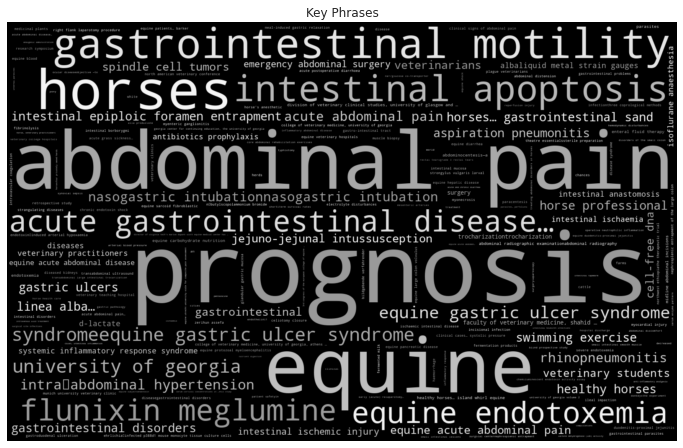

In [ ]:
import random

# function from https://amueller.github.io/word_cloud/auto_examples/a_new_hope.html
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)


# Create a simple wordcloud with the key phrases after removing equine colic
phrases_df = eqcol_df.key_phrase.value_counts().to_dict()

# Create the figure and title
plt.figure(figsize=(12, 8))

# Generate the wordcloud from frequencies
wc = WordCloud(width = 1600, 
               height=1000, 
               margin=10, 
               random_state=1).generate_from_frequencies(phrases_df)

# Display the fitted and recolored wordcloud
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")

# Turn axis off to get rid of axis numbers
plt.axis("off")

# Create title
plt.title("Key Phrases")

# save to file
wc.to_file("key_phrases.png")

plt.show()

In [ ]:
eqcol_df.head(20)

,index,text,key_phrase,label,DocumentSimilarity,MMRScore,sentence
0,0,Prospective study of equine colic risk factorsA1 year prospective study was conducted on 31 horse farms to identify risk factors for equine colic. Farms were randomly selected from a list from 2 adjacent counties of Virginia and …,farms,Professional_or_Occupational_Group,0.436415395613195,0.26184924777287083,1
2,2,"Prospective study of equine colic incidence and mortalityA prospective study of one year was conducted on 31 horse farms to obtain population based estimates of incidence, morbidity and mortality rates of equine colic. Farms with greater …",horse farms,Manufactured_Object,0.49957747466204644,0.299746496708083,0
7,7,Prognosticating equine colicPrognosticating survival in horses with colic is challenging because of the number of diseases and pathophysiologic processes that can cause the behavior. Although the treatment of …,diseases,Disease_or_Syndrome,0.49646389133268837,0.2978783466362346,0
8,8,"Clinical evaluation of blood lactate levels in equine colic… Donawick and Hiza (1973) reported that in 9 cases of equine colic, blood lactate levels were … evaluate the rise of blood lactate levels in equine colic cases and to determine if such levels …",blood lactate levels,Laboratory_Procedure,0.7088511073270776,0.4253106812965739,0
11,11,Prognosis in equine colic: a study of individual variables used in case assessmentThe individual merit of the use of 43 variables to assess the prognosis of equine colic cases was examined. The following variables revealed highly significant (P<0.001) differences …,prognosis,Health_Care_Activity,0.6036541555461429,0.36219250771992234,0
15,15,Could it be colic? Horse-owner decision making and practices in response to equine colicLittle is known about lay understanding and decision making in response to colic. Horse-owners/carers are key to identifying colic and initiating veterinary intervention. Understanding …,veterinary intervention,Health_Care_Activity,0.55459835119304,0.3327590239384791,2
17,17,Prognosis in equine colic patients using multivariable analysis.… Multivariable models can also be utilized in clinical prediction; in this study they were used to predict prognosis of equine colic cases. Previous multivariable models formulated for use …,prognosis,Health_Care_Activity,0.6348443893751134,0.38090664876093777,1
20,20,Evaluation of peritoneal fluid lactate as a marker of intestinal ischaemia in equine colic… Elevated serum glucose has been described in the initial phases of endotoxaemia and glucose values >13.9 mmol/l have been associated with poor prognosis in equine colic. …,intestinal ischaemia,Disease_or_Syndrome,0.7435845194522867,0.44615072939980843,0
23,23,"Equine colicColic, defined as any abdominal pain, has resulted in the death of horses throughout recorded history. The earliest treatments may have been acupuncture. The use of drugs for …",abdominal pain,Sign_or_Symptom,0.5939570059068402,0.35637421770514266,0
32,32,"Prospective survey of veterinary practitioners' primary assessment of equine colic: clinical features, diagnoses, and treatment of 120 cases of large colon …… Data were collected prospectively from veterinary practitioners on the primary assessment of equine colic cases over a 12 month period. Inclusion criteria were a diagnosis of primary …",veterinary practitioners,Professional_or_Occupational_Group,0.557615415264728,0.33456926245342433,0
